# Optimization of an agent in Flappy Bird game using Genetic Algorithm

In this project we will develop an agent that plays Flappy Bird using Neural Networks and Genetic Algorithm

# Basic Imports

In [81]:
import pygame
import random
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Constants

In [82]:
SCREEN_WIDTH = 400
SCREEN_HEIGHT = 600
PIPE_SPEED = 4   # How many pixels the pipe moves to the left each frame
GRAVITY = 0.5    # How much the bird's vertical speed increases downward in each frame
BIRD_JUMP = -8
POPULATION_SIZE = 100  # How many birds (agents) do we test simultaneously in one round (generation)
MUTATION_RATE = 0.15   # Strength of "gene"(weights) change. If it is 0.15, we change the weights by approximately 15%.
MUTATION_STRENGTH = 0.02

# Neural Network

Inputs(6) : y bird position(relative to the centre of the gap), y top pipe, y lower pipe, horizontal distance, bird velocity, gap size

Hidden layer : 16 nodes

Output layer : 1 node

In [83]:
class BirdBrain(nn.Module):
    def __init__(self):
        super(BirdBrain, self).__init__()

        self.fc = nn.Sequential(
            nn.Linear(6, 16),  #6 inputs, hidden layer has 18 nodes
            nn.ReLU(),  #activation, if the signal is negative, set it to zero
            nn.Linear(16, 1),  #from hidden layer to output layer that determines wether the bird should jump
            nn.Tanh(),        # Output mapped to range [-1, 1]
        )

        for param in self.parameters():  # turning off "gradient learning"
            param.requires_grad = False

    def forward(self, x):
        return self.fc(x)

# Game Logic

**Agent**:

In [84]:
class Bird:
    def __init__(self):
        self.y = SCREEN_HEIGHT // 2
        self.vel = 0
        self.brain = BirdBrain()
        self.fitness = 0   # Cumulative performance metric for GA
        self.alive = True 
        self.score = 0     # Number of pipes successfully passed

    def jump(self):
        self.vel = BIRD_JUMP

    def update(self, pipe_info):
        if not self.alive:
            return

        # Reward for surviving the current frame
        self.fitness += 0.1

        # Physics update
        self.vel += GRAVITY
        self.y += self.vel

        pipe_center = (pipe_info['top'] + pipe_info['bottom']) / 2

        # Input Normalization for the Neural Network
        inputs = torch.tensor(
            [
                self.y / SCREEN_HEIGHT,                # Bird's vertical position
                self.vel / 15.0,                       # Bird's velocity
                pipe_info['top'] / SCREEN_HEIGHT,      # Top pipe edge
                pipe_info['bottom'] / SCREEN_HEIGHT,   # Bottom pipe edge
                pipe_info['dist'] / SCREEN_WIDTH,      # Distance to the next pipe
                (self.y - pipe_center) / SCREEN_HEIGHT # Relative distance to gap center
            ],
            dtype=torch.float32
        )

        # Decision Making: If output > 0.5, the bird jumps
        if self.brain(inputs).item() > 0.5:
            self.jump()
            self.fitness -= 0.5  # Penalty for excessive jumping to encourage efficiency

        # Boundary Collision Check
        if self.y < 0 or self.y > SCREEN_HEIGHT:
            self.fitness -= 10   # Significant penalty for hitting floor/ceiling
            self.alive = False

In [85]:
class Pipe:
    def __init__(self, x):
        self.x = x
        self.gap = random.randint(120, 180)
        self.top = random.randint(50, SCREEN_HEIGHT - self.gap - 50)
        self.bottom = self.top + self.gap
        self.passed = False
    
    def update(self):
        self.x -= PIPE_SPEED

# Genetic Algorithm

In [86]:
def mutate(brain):
    for param in brain.parameters():
        # Mutation mask determines which weights are modified
        mask = torch.rand_like(param) < MUTATION_RATE
        
        # 90% Fine-tuning (small noise), 10% Exploration (large noise)
        if random.random() > 0.1:
            noise = torch.randn_like(param) * MUTATION_STRENGTH
        else:
            noise = torch.randn_like(param) * (MUTATION_STRENGTH * 5)
            
        param.data += mask * noise

In [87]:
def crossover(parent1, parent2, child):
    for p1, p2, c in zip(parent1.parameters(), parent2.parameters(), child.parameters()):
        # 50/50 chance to inherit gene from either parent
        mask = torch.rand_like(p1) > 0.5
        c.data = torch.where(mask, p1.data, p2.data)

# Game Loop

Gen 1 | Best Fitness: 1 | Avg Fitness: -6 | Max Score: 0
Gen 2 | Best Fitness: 1 | Avg Fitness: -7 | Max Score: 0
Gen 3 | Best Fitness: 963 | Avg Fitness: 2 | Max Score: 1
Gen 4 | Best Fitness: 959 | Avg Fitness: 2 | Max Score: 1
Gen 5 | Best Fitness: 4 | Avg Fitness: -7 | Max Score: 0
Gen 6 | Best Fitness: 965 | Avg Fitness: -1 | Max Score: 1
Gen 7 | Best Fitness: 971 | Avg Fitness: 41 | Max Score: 1
Gen 8 | Best Fitness: 1012 | Avg Fitness: 63 | Max Score: 1
Gen 9 | Best Fitness: 970 | Avg Fitness: 66 | Max Score: 1
Gen 10 | Best Fitness: 971 | Avg Fitness: 176 | Max Score: 1
Gen 11 | Best Fitness: 970 | Avg Fitness: 104 | Max Score: 1
Gen 12 | Best Fitness: 1978 | Avg Fitness: 114 | Max Score: 2
Gen 13 | Best Fitness: 1979 | Avg Fitness: 195 | Max Score: 2
Gen 14 | Best Fitness: 970 | Avg Fitness: 60 | Max Score: 1
Gen 15 | Best Fitness: 970 | Avg Fitness: 201 | Max Score: 1
Gen 16 | Best Fitness: 1976 | Avg Fitness: 499 | Max Score: 2
Gen 17 | Best Fitness: 971 | Avg Fitness: 278 |

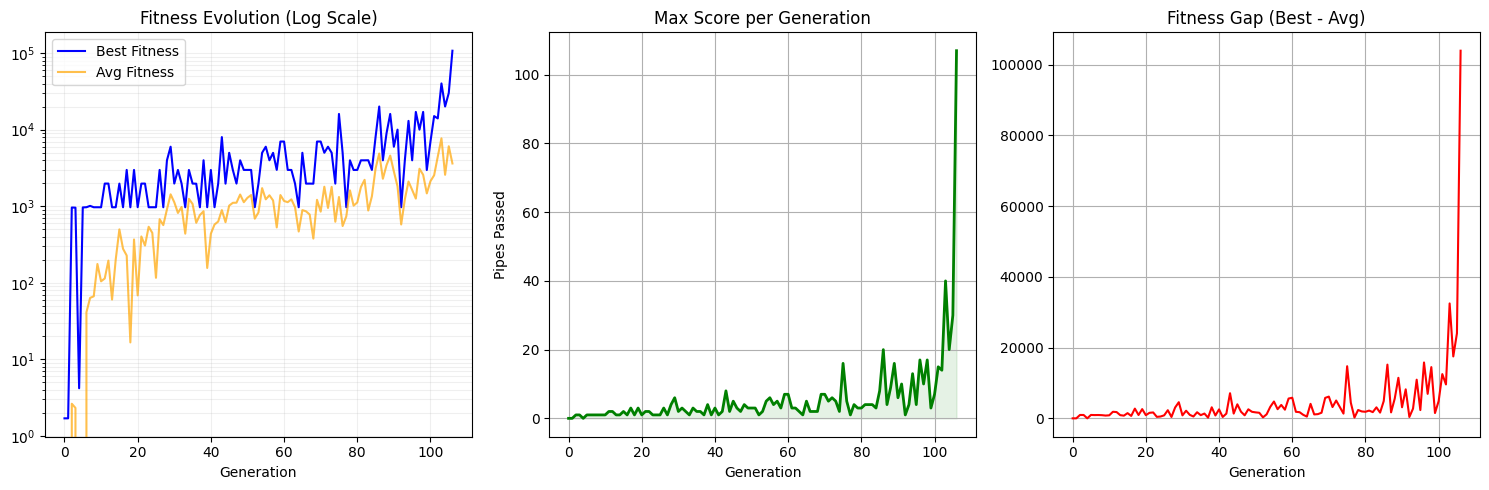

In [88]:
def main():
    pygame.init()
    screen = pygame.display.set_mode((SCREEN_WIDTH, SCREEN_HEIGHT))
    clock = pygame.time.Clock()
    font = pygame.font.SysFont("Arial", 24)

    population = [Bird() for _ in range(POPULATION_SIZE)]
    generation = 1
    best_fitness_history = []
    avg_fitness_history = []
    max_score_history = []

    running_program = True

    while running_program: 
        # Spawn initial pipe with offset to allow birds to stabilize
        pipes = [Pipe(SCREEN_WIDTH + 400)]
        next_pipe_dist = random.randint(200, 350)
        running_generation = True

        while running_generation:
            screen.fill((135, 206, 235)) # Sky Blue

            # --- Input/Event Handling ---
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    running_program = False
                    running_generation = False

            # --- Pipe Management Logic ---
            if pipes[-1].x < SCREEN_WIDTH - next_pipe_dist:
                pipes.append(Pipe(SCREEN_WIDTH))
                next_pipe_dist = random.randint(200, 350)

            if pipes[0].x < -50:
                pipes.pop(0)

            # Determine which pipe is currently the target for the AI
            target_pipe = pipes[0]
            if target_pipe.x + 50 < 50: 
                target_pipe = pipes[1]

            pipe_info = {
                'top': target_pipe.top, 
                'bottom': target_pipe.bottom, 
                'dist': target_pipe.x, 
                'gap': target_pipe.gap
            }

            # --- Bird Updates and Collision ---
            all_dead = True
            for bird in population:
                if bird.alive:
                    all_dead = False
                    bird.update(pipe_info)

                    # Reward for passing the pipe entry
                    if not target_pipe.passed and target_pipe.x < 50:
                        bird.fitness += 1000
                        bird.score += 1

                    # Collision Detection
                    if target_pipe.x < 50 + 15 and target_pipe.x + 50 > 50 - 15:
                        if bird.y - 15 < target_pipe.top or bird.y + 15 > target_pipe.bottom:
                            bird.fitness -= 50 
                            bird.alive = False
                    
                    pygame.draw.circle(screen, (255, 255, 0), (50, int(bird.y)), 15)

            if not target_pipe.passed and target_pipe.x < 50:
                target_pipe.passed = True

            if all_dead:
                running_generation = False

            # --- Rendering Pipes ---
            for pipe in pipes:
                pipe.update()
                pygame.draw.rect(screen, (0, 255, 0), (pipe.x, 0, 50, pipe.top))
                pygame.draw.rect(screen, (0, 255, 0), (pipe.x, pipe.bottom, 50, SCREEN_HEIGHT))

            # UI Overlays
            stats_text = font.render(f"Gen: {generation}  Alive: {sum(b.alive for b in population)}", True, (0,0,0))
            screen.blit(stats_text, (10, 10))

            pygame.display.flip()
            clock.tick(0) # Maximize speed for training

        if not running_program: break 

        # --- Generation Post-Processing & Evolution ---
        population.sort(key=lambda x: x.fitness, reverse=True)
        
        best_f = population[0].fitness
        avg_f = sum(b.fitness for b in population) / len(population)
        best_s = max(b.score for b in population)

        best_fitness_history.append(best_f)
        avg_fitness_history.append(avg_f)
        max_score_history.append(best_s)

        print(f"Gen {generation} | Best Fitness: {int(best_f)} | Avg Fitness: {int(avg_f)} | Max Score: {best_s}")

        # Stopping Criterion
        if best_s >= 100:
            print(f"VICTORY! Agent passed 100 pipes in Generation {generation}.")
            running_program = False

        # --- Selection & Elitism ---
        breeding_pool = population[:15] 
        new_population = []

        # Carry over top 3 elites directly
        for i in range(3):
            elite = Bird()
            elite.brain.load_state_dict(population[i].brain.state_dict())
            new_population.append(elite)
            
        # Create offspring for the rest of the population
        while len(new_population) < POPULATION_SIZE:
            p1, p2 = random.sample(breeding_pool, 2)
            child = Bird()
            crossover(p1.brain, p2.brain, child.brain)
            mutate(child.brain)
            new_population.append(child)

        population = new_population
        generation += 1

    # --- Data Visualization & Reporting ---
    pygame.quit()
    
    plt.figure(figsize=(15, 5))

    # Graph 1: Fitness Progression (Log Scale)
    plt.subplot(1, 3, 1)
    plt.semilogy(best_fitness_history, label="Best Fitness", color='blue')
    plt.semilogy(avg_fitness_history, label="Avg Fitness", color='orange', alpha=0.7)
    plt.title("Fitness Evolution (Log Scale)")
    plt.xlabel("Generation")
    plt.legend()
    plt.grid(True, which="both", ls="-", alpha=0.2)

    # Graph 2: Score Progression
    plt.subplot(1, 3, 2)
    plt.plot(max_score_history, color='green', linewidth=2)
    plt.fill_between(range(len(max_score_history)), max_score_history, color='green', alpha=0.1)
    plt.title("Max Score per Generation")
    plt.xlabel("Generation")
    plt.ylabel("Pipes Passed")
    plt.grid(True)

    # Graph 3: Training Gap (Exploration Potential)
    plt.subplot(1, 3, 3)
    plt.plot(np.array(best_fitness_history) - np.array(avg_fitness_history), color='red')
    plt.title("Fitness Gap (Best - Avg)")
    plt.xlabel("Generation")
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(f"performance_report_gen_{generation}.png")
    print(f"Performance report saved as: performance_report_gen_{generation}.png")
    plt.show()

if __name__ == "__main__":
    main()